# Crime Type Classification using LAPD Data (2020–Present)
 
### **Dataset Description**
This project uses the publicly available **Crime Data from 2020 to Present** published by the **Los Angeles Police Department (LAPD)**.  
Each row in the dataset represents a single reported crime incident and includes:

- When the crime occurred (date and time)
- Location (police area, reporting district, latitude/longitude)
- Victim demographics (age, sex, descent)
- Crime type classification
- Context information (e.g., where it happened, whether a weapon was used)

**Goal:**  
We aim to **predict the type of crime** (`Crm Cd Desc`) using relevant victim, location, and context features.

**Dataset Source:**  
Los Angeles Open Data Portal – *Crime Data from 2020 to Present*
https://catalog.data.gov/dataset/crime-data-from-2020-to-present


## Crime Category Grouping for Classification

The original LAPD dataset contains **over 140 unique crime labels**, many of which differ only by severity level, value, victim type, or whether the crime was attempted or completed.  
For example:

- **Bike – Stolen** and **Bike – Attempted Stolen**
- **Petty Theft**, **Grand Theft**, and **Employee Theft**
- **Burglary** vs. **Burglary from Vehicle**
- **Battery**, **Battery on a Police Officer**, and **Simple Assault**

Although legally distinct, these variations represent **the same type of criminal action**, and predicting them as separate labels would produce excessive class imbalance, unnecessary classifier complexity, and reduced predictive insight.

To support meaningful machine learning classification, we grouped crimes into broader **action-based categories**, where labels represent **what type of crime occurs**, not small legal variations of it. The grouping follows four principles:

- Crimes are merged when they differ only by value, victim category, or attempt/completion.
- Theft-related crimes (shoplifting, bunco scams, employee theft, etc.) are treated as **Theft**.
- Vehicle theft remains a separate category from general theft due to unique patterns and predictive features.
- All sexual crimes (rape, sexual battery, sodomy, child pornography, lewd conduct, etc.) are grouped into **Sex Offense**

We do not aim to predict specific penal code labels. Instead, we predict **the type of crime being reported**, based on victim demographics, context, and location features.


In [13]:
import sys
import os
from mysklearn.mypreprocessing import load_raw_crime_data, extract_features

# Add project root path manually
sys.path.append(os.path.abspath(".."))
sys.path.append(os.path.abspath("../.."))


In [14]:
# Load raw CSV (path is relative to notebooks/ folder)
raw_df = load_raw_crime_data("../data/Crime_Data_from_2020_to_Present.csv")

# Apply cleaning + feature extraction + label grouping
clean_df = extract_features(raw_df)

# Display some rows to verify
clean_df.head()


,Vict Sex,Vict Descent,Premis Desc,AREA NAME,Vict Age Group,Time Period,Crime Category
0,M,H,SINGLE FAMILY DWELLING,N Hollywood,young adult,morning,Fraud
1,M,H,SIDEWALK,N Hollywood,young adult,evening,Assault
2,M,W,SINGLE FAMILY DWELLING,Van Nuys,young adult,afternoon,Fraud
3,F,A,STREET,Wilshire,adult,afternoon,Other
4,M,H,ALLEY,Pacific,middle age,evening,Other


In [15]:
print(clean_df.columns)
clean_df.sample(5)


Index(['Vict Sex', 'Vict Descent', 'Premis Desc', 'AREA NAME',
       'Vict Age Group', 'Time Period', 'Crime Category'],
      dtype='object')


,Vict Sex,Vict Descent,Premis Desc,AREA NAME,Vict Age Group,Time Period,Crime Category
787447,X,X,POLICE FACILITY,Olympic,NaN,morning,Other
801706,M,H,PARK/PLAYGROUND,West Valley,child,morning,Other
16607,X,X,OTHER BUSINESS,Olympic,NaN,late night,Burglary
834876,M,H,MTA BUS,Van Nuys,young adult,late night,Threats/Harassment
691740,M,H,SIDEWALK,Wilshire,adult,morning,Assault


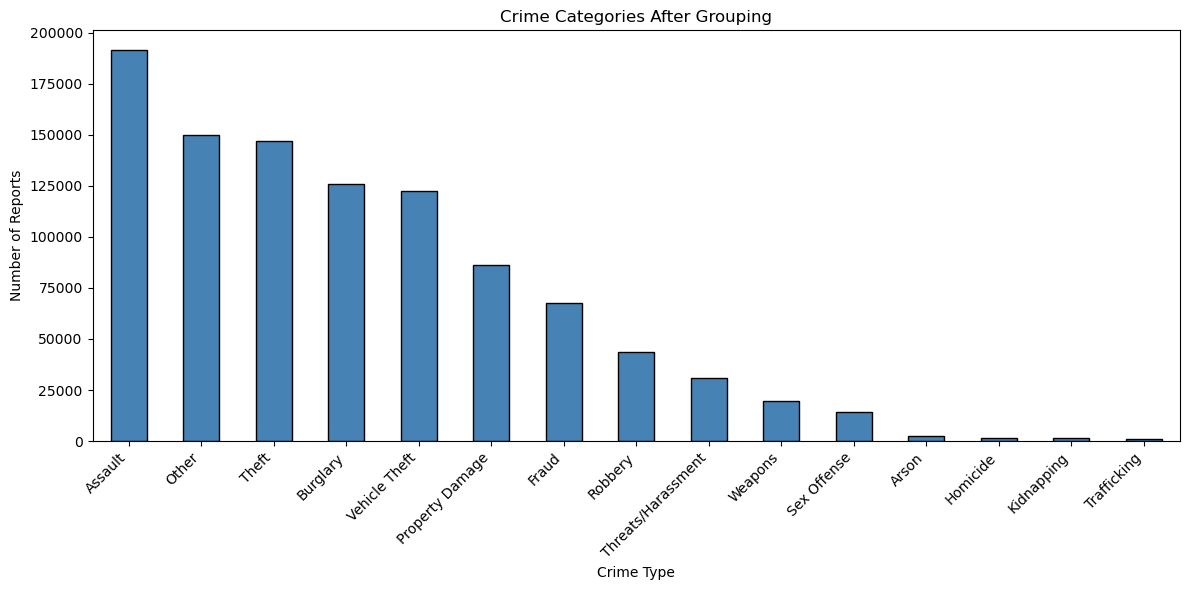

In [16]:
import matplotlib.pyplot as plt

crime_counts = clean_df["Crime Category"].value_counts()

plt.figure(figsize=(12, 6))
crime_counts.plot(kind="bar", color="steelblue", edgecolor="black")

plt.title("Crime Categories After Grouping")
plt.xlabel("Crime Type")
plt.ylabel("Number of Reports")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


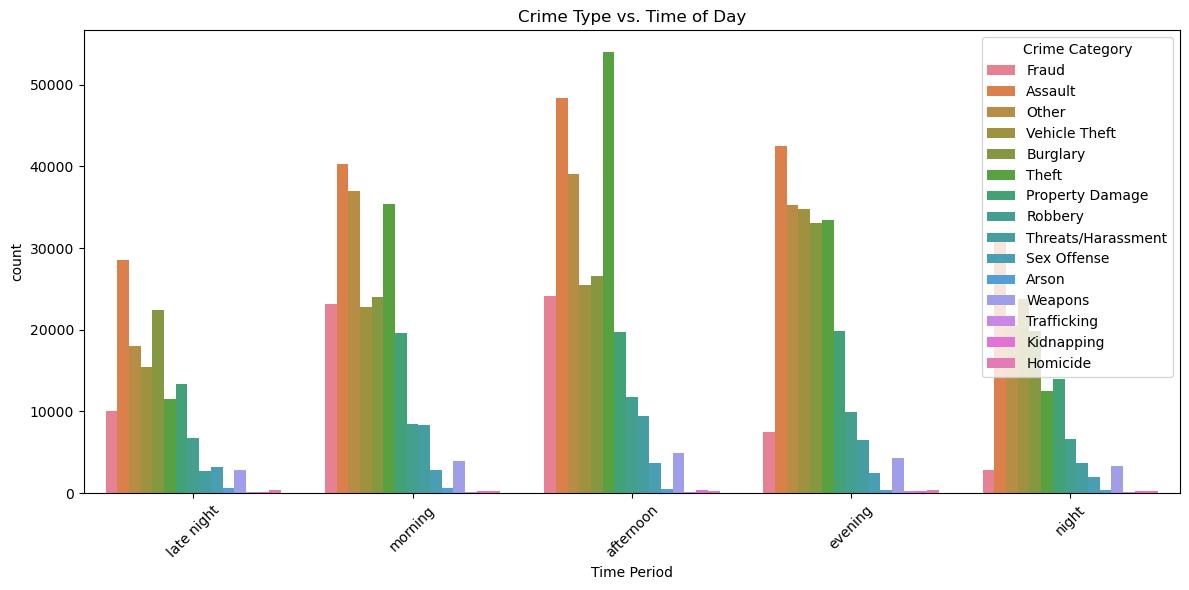

In [17]:
import seaborn as sns
plt.figure(figsize=(12,6))
sns.countplot(data=clean_df, x="Time Period", hue="Crime Category")
plt.title("Crime Type vs. Time of Day")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


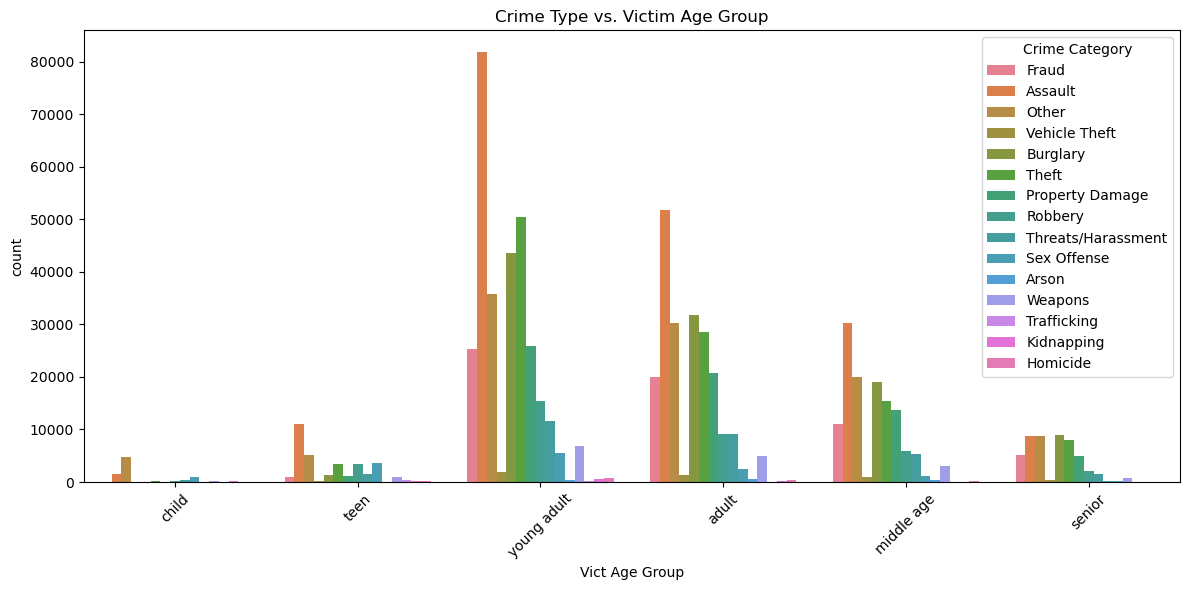

In [18]:
plt.figure(figsize=(12,6))
sns.countplot(data=clean_df, x="Vict Age Group", hue="Crime Category")
plt.title("Crime Type vs. Victim Age Group")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
